In [0]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756051 sha256=949a205fd3c989d342fa09b19cfaeee552bca0b59a08e4fc74b303e7fc582a4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_cf9oyha/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


Reference:
https://github.com/zhaohuicici/Time-Series-Model/blob/master/Python时间序列-奶牛产量.py

# Import packages

In [0]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


In [0]:
from datetime import datetime
# import numpy to generate toy data, and matplotlib to plot it
import numpy as np
import matplotlib.pyplot as plt
# set up matplotlib to show the figures inline
plt.ion()
%matplotlib inline
# import the LinearRegression method from scikit-learn
from sklearn.linear_model import LinearRegression

In [0]:
import itertools
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import os
os.getcwd()

'/content'

# Big query to get data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
%%bigquery --project alert-ground-261008 output
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35
group by time
order by time
#output.sort_values(by=['time'],inplace=True)

# Visualise time series

In [0]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<=360:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',crnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im = ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

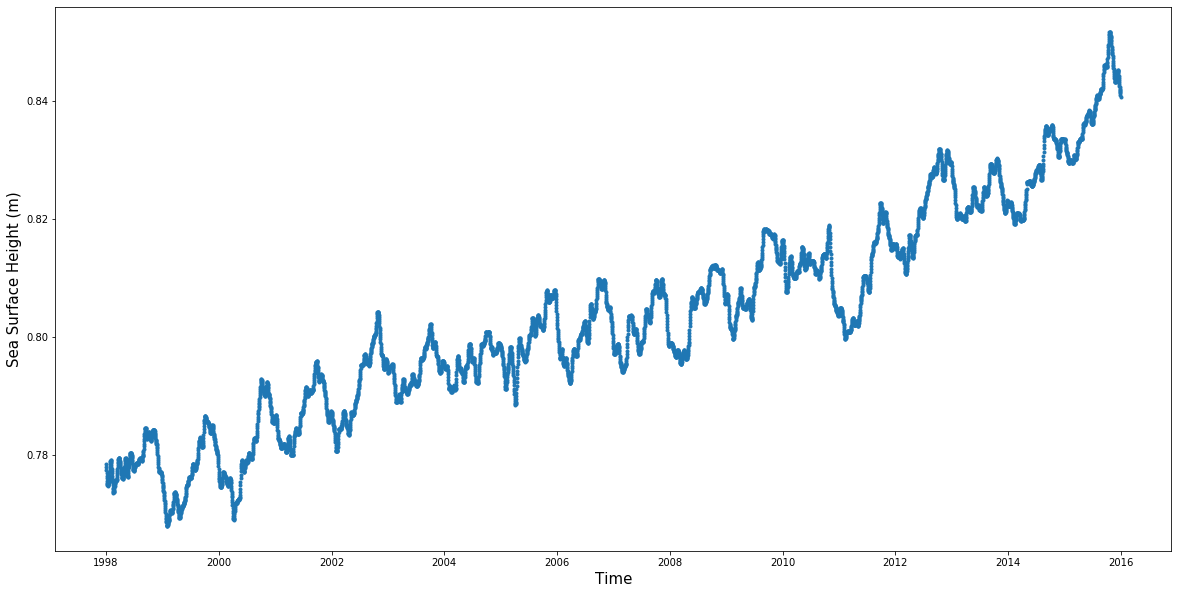

In [0]:
# plot original data
plt.figure(figsize=(20,10))
plot_ts(output.time,output.mean_ssh,'.','Sea Surface Height (m)')

In [0]:
#dataframe
ts = pd.Series(np.array(output['mean_ssh'].astype('float64')),
               index=pd.date_range('19980101','20151231',freq='D'))

In [0]:
def test_stationarity(timeseries,lags):
    #rolling average ,std,difference
    plt.figure(figsize=(10,10))
    rolmean=timeseries.rolling(lags).mean()
    ts_diff = timeseries - timeseries.shift(lags)
    rolstd=timeseries.rolling(lags).std()

    orig = timeseries.plot(color = 'blue',label='Original')
    mean = rolmean.plot(color = 'red',label='Rolling 365 Mean')
    plt.show(block=False)
    std = rolstd.plot(color = 'black',label='Rolling 365 Std')
    diff = ts_diff.plot(color = 'green',label = 'Diff 1')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation and Diff 1')
    l1 = plt.axhline(y=0,  linewidth=1, color='yellow')
    
    plt.figure(figsize=(20,10))
    plt.show(block=False)
    #adf--AIC test
    print ('Result of Augment Dickry-Fuller test--AIC')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used',
    'Number of observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value(%s)'%key]=value
    print (dfoutput)
    #adf--BIC test
    print('-------------------------------------------')
    print ('Result of Augment Dickry-Fuller test--BIC')
    dftest=adfuller(timeseries,autolag='BIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used',
    'Number of observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value(%s)'%key]=value
    print (dfoutput)



#ARIMA model

## Test of stationarity(original data)
> 

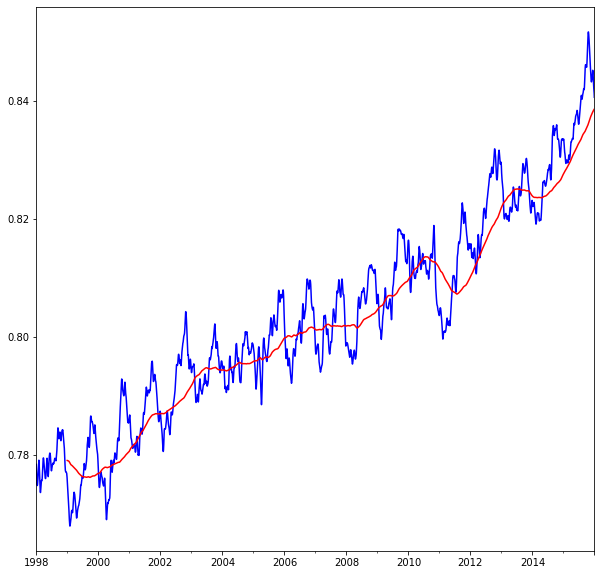

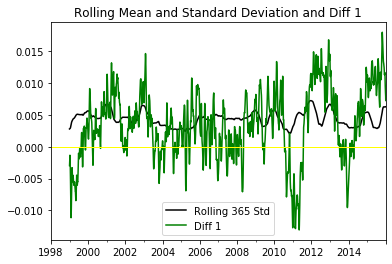

<Figure size 1440x720 with 0 Axes>

Result of Augment Dickry-Fuller test--AIC
Test Statistic                   -1.245338
p-value                           0.653795
Lags Used                        32.000000
Number of observations Used    6541.000000
Critical value(1%)               -3.431350
Critical value(5%)               -2.861982
Critical value(10%)              -2.567005
dtype: float64
-------------------------------------------
Result of Augment Dickry-Fuller test--BIC
Test Statistic                   -1.155615
p-value                           0.692392
Lags Used                         9.000000
Number of observations Used    6564.000000
Critical value(1%)               -3.431347
Critical value(5%)               -2.861980
Critical value(10%)              -2.567004
dtype: float64


In [0]:
# the test of stationarity of original time series
test_stationarity(ts,365)
##as we can see in the figures below, first order difference is not stable(p_value is greater than 0.05), then we can try to decompose the time series.

## Decompose original data to get the trend, seasonality and residual.

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
def model_decompose(ts):
  ts.interpolate(inplace = False)
  decomposition=seasonal_decompose(ts,freq=365)
  ts_trend=decomposition.trend
  ts_seasonal=decomposition.seasonal
  ts_resid=decomposition.resid
  decomposition.plot()
  plt.show()
  return  ts_trend,ts_seasonal,ts_resid



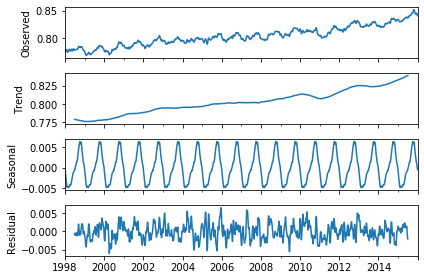

In [0]:
ts_trend,ts_seasonal,ts_resid=model_decompose(ts)

## Simulate the trend and the residual, and aggregate these three parts as fitted data.


### 1.trend

Since second order model is stable, we can apply ACF AND PACF to choose the value of orders.


In [0]:
def autocorrelation(timeseries, lags):
  '''
  acf and pacf can help us choose the orders
  '''
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(211)
  sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
  ax2 = fig.add_subplot(212)
  sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
  plt.show()

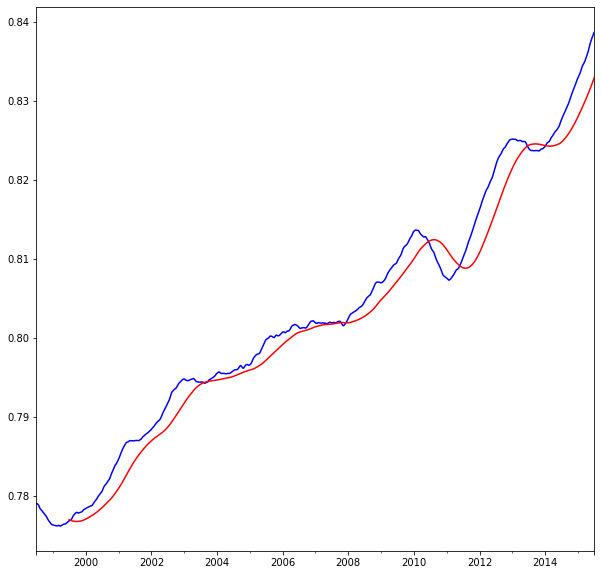

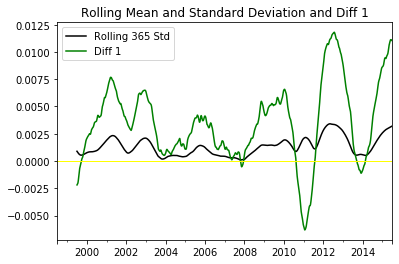

<Figure size 1440x720 with 0 Axes>

Result of Augment Dickry-Fuller test--AIC
Test Statistic                    0.296243
p-value                           0.977171
Lags Used                        27.000000
Number of observations Used    6182.000000
Critical value(1%)               -3.431408
Critical value(5%)               -2.862008
Critical value(10%)              -2.567019
dtype: float64
-------------------------------------------
Result of Augment Dickry-Fuller test--BIC
Test Statistic                    0.820684
p-value                           0.991963
Lags Used                        10.000000
Number of observations Used    6199.000000
Critical value(1%)               -3.431405
Critical value(5%)               -2.862006
Critical value(10%)              -2.567018
dtype: float64


In [0]:
# first order difference of ts_trend (the trend of original data)
test_stationarity(ts_trend.dropna(),365)
# due to the function(seasonality_decompose) it self, there will be some missing value, just drop them.
# first order difference is not stable, we try to do the second order difference

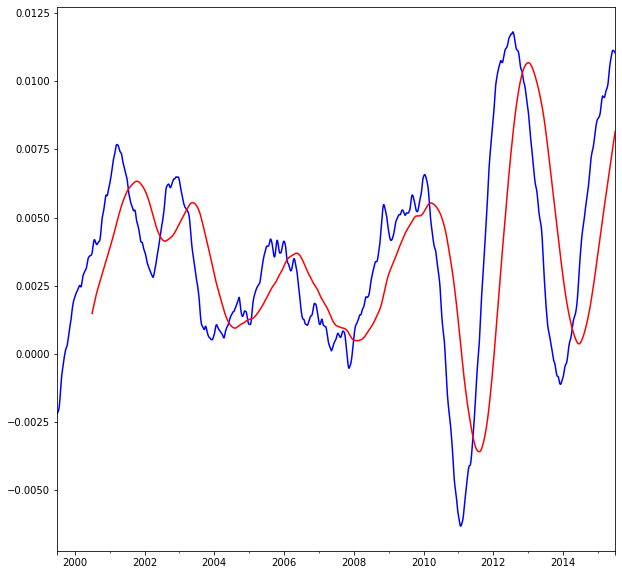

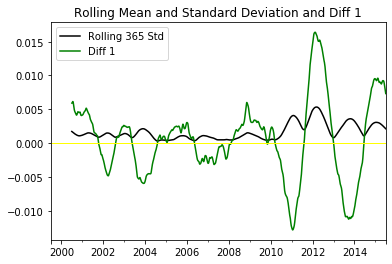

<Figure size 1440x720 with 0 Axes>

Result of Augment Dickry-Fuller test--AIC
Test Statistic                   -3.623438
p-value                           0.005328
Lags Used                        32.000000
Number of observations Used    5812.000000
Critical value(1%)               -3.431476
Critical value(5%)               -2.862037
Critical value(10%)              -2.567035
dtype: float64
-------------------------------------------
Result of Augment Dickry-Fuller test--BIC
Test Statistic                   -3.296752
p-value                           0.015024
Lags Used                        10.000000
Number of observations Used    5834.000000
Critical value(1%)               -3.431471
Critical value(5%)               -2.862036
Critical value(10%)              -2.567034
dtype: float64


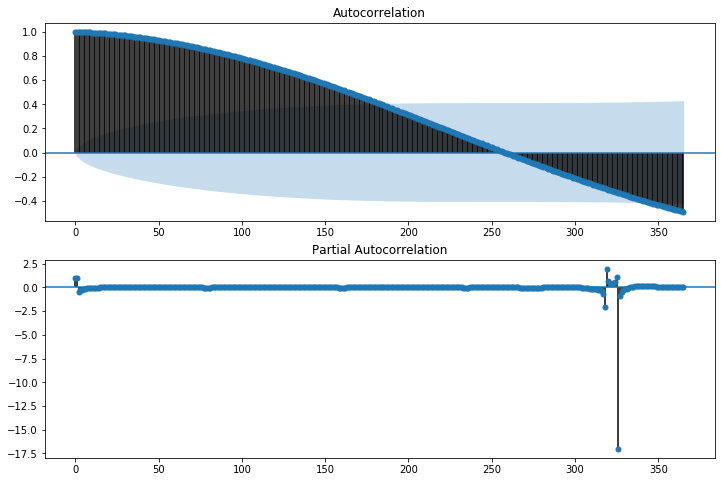

In [0]:
# the second order differece is stabel, so we decide the value of 'd' is 2 in ARIMA
test_stationarity(ts_trend.diff(365).dropna(),365)
autocorrelation(ts_train_trend_diff1.diff(365).dropna(), 365)

### 2. residual

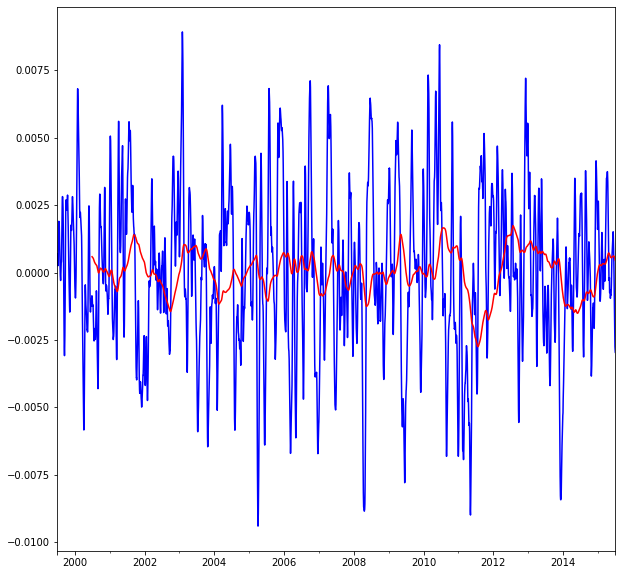

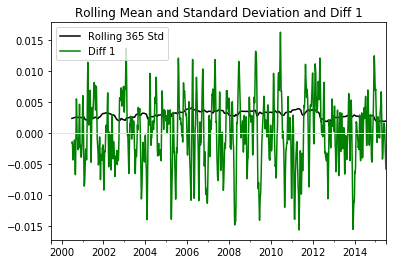

<Figure size 1440x720 with 0 Axes>

Result of Augment Dickry-Fuller test--AIC
Test Statistic                -9.733602e+00
p-value                        8.869990e-17
Lags Used                      2.200000e+01
Number of observations Used    5.822000e+03
Critical value(1%)            -3.431474e+00
Critical value(5%)            -2.862037e+00
Critical value(10%)           -2.567034e+00
dtype: float64
-------------------------------------------
Result of Augment Dickry-Fuller test--BIC
Test Statistic                -1.050474e+01
p-value                        1.061453e-18
Lags Used                      9.000000e+00
Number of observations Used    5.835000e+03
Critical value(1%)            -3.431471e+00
Critical value(5%)            -2.862035e+00
Critical value(10%)           -2.567034e+00
dtype: float64


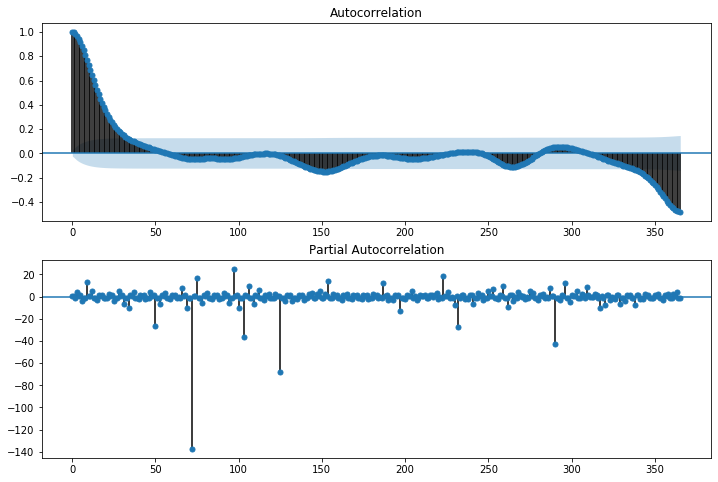

In [0]:
# residual
test_stationarity(ts_resid.diff(365).dropna(),365)
ts_resid_diff1=ts_resid.diff(365).dropna()
autocorrelation(ts_resid_diff1,365)



(array([  6.,   7.,  18.,  22.,  29.,  51., 113.,  91., 127., 189., 235.,
        273., 308., 365., 403., 400., 427., 447., 433., 411., 310., 286.,
        280., 211., 189., 149.,  88.,  96.,  81.,  42.,  40.,  28.,  18.,
         24.,   5.,   8.]),
 array([-0.00605969, -0.00570968, -0.00535966, -0.00500965, -0.00465964,
        -0.00430962, -0.00395961, -0.0036096 , -0.00325959, -0.00290957,
        -0.00255956, -0.00220955, -0.00185953, -0.00150952, -0.00115951,
        -0.00080949, -0.00045948, -0.00010947,  0.00024054,  0.00059056,
         0.00094057,  0.00129058,  0.0016406 ,  0.00199061,  0.00234062,
         0.00269064,  0.00304065,  0.00339066,  0.00374067,  0.00409069,
         0.0044407 ,  0.00479071,  0.00514073,  0.00549074,  0.00584075,
         0.00619077,  0.00654078]),
 <a list of 36 Patch objects>)

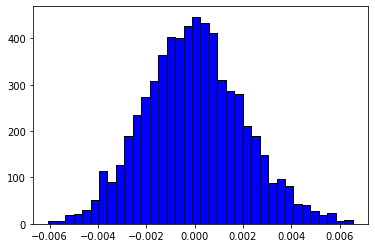

In [0]:
plt.hist(ts_resid, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

## Find the model to fit trend


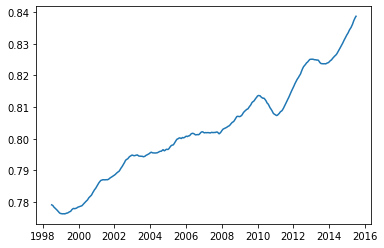

In [0]:
plot(ts_trend)

In [0]:
model = ARIMA(ts_trend.dropna(), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
output = model_fit.forecast()


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 6209
Model:                 ARIMA(5, 1, 0)   Log Likelihood               89042.379
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 20 Jan 2020   AIC                        -178070.759
Time:                        18:57:40   BIC                        -178023.622
Sample:                    07-03-1998   HQIC                       -178054.418
                         - 07-02-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.34e-06   2.61e-06      3.581      0.000    4.23e-06    1.45e-05
ar.L1.D.y      2.2256      0.012    184.692      0.000       2.202       2.249
ar.L2.D.y     -1.2146      0.030    -40.494      0.0

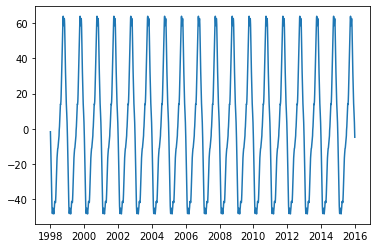

In [0]:
plot(ts_seasonal)

The shape of X is (6210, 2)
The shape of y is (6210,)
Model coefficients for [a1, a2, a3,a4]: [3.46965372e-42 5.45873825e-24]
Model coefficient for b: -0.7703005070406619


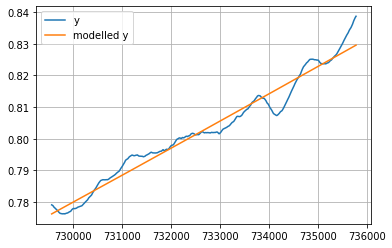

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.interpolate(inplace = False)
decomposition=seasonal_decompose(ts,freq=365)
ts_trend=decomposition.trend
ts_seasonal=decomposition.seasonal
ts_resid=decomposition.resid

ts_trend2=pd.Series(ts_trend.values,index=date2num(ts_trend.index),name='predict')
t=ts_trend2.dropna().index
w=1/365.25
x1 = t
x2 = t*t*t*t
x4 = np.sin(2*np.pi*w*t)
x5 = np.cos(2*np.pi*w*t)

X = np.vstack((x1,x2)).T
y= ts_trend.dropna().values
print('The shape of X is {}'.format(X.shape))
print('The shape of y is {}'.format(y.shape))

# 2: create the model, as before
model = LinearRegression(fit_intercept=True)

# 3: fit the model, as before
model.fit(X,y)

print('Model coefficients for [a1, a2, a3,a4]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

# 4: get predicted values for y, as before
y_trend = model.predict(X)

# 5: plot the real and modelled values
plt.figure()
plt.plot(t,y,label='y')
plt.plot(t,y_trend,label='modelled y')
plt.legend()
plt.grid()


In [0]:
def arima_performance(data,order1):
  model=ARIMA(data,order=order1)
  results_arima=model.fit(disp=-1)
  print(results_arima.summary())
  results_arima_value=results_arima.fittedvalues
  
  start_index = '2005-01-01'
  end_index = '2050-12-31'
  result_future=results_arima.predict(start=start_index, end=end_index)
  results_arima.plot_predict(start=start_index, end=end_index)

  return results_arima_value,result_future


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 6573
Model:                 ARIMA(5, 1, 0)   Log Likelihood               57787.279
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 20 Jan 2020   AIC                        -115560.558
Time:                        19:10:07   BIC                        -115513.023
Sample:                    01-02-1998   HQIC                       -115544.126
                         - 12-31-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.662e-06      8e-06      1.083      0.279   -7.02e-06    2.43e-05
ar.L1.D.y      1.2435      0.012    101.117      0.000       1.219       1.268
ar.L2.D.y      0.0418      0.019      2.144      0.0

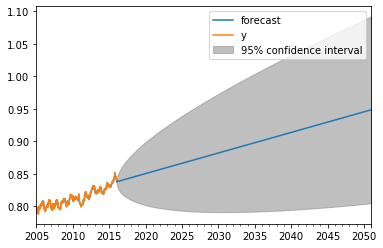

In [0]:
results_arima_value_trend,result_future_trend=arima_performance(ts,(5,1,0))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5844
Model:                     ARMA(1, 0)   Log Likelihood               42134.071
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 20 Jan 2020   AIC                         -84262.142
Time:                        19:10:34   BIC                         -84242.123
Sample:                    01-01-1999   HQIC                        -84255.181
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.839e-05      0.001     -0.083      0.934      -0.001       0.001
ar.L1.y        0.9962      0.001    906.128      0.000       0.994       0.998
                                    Roots           

<Figure size 1440x720 with 0 Axes>

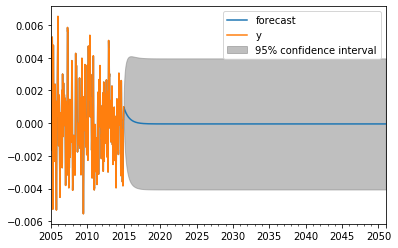

In [0]:
plt.figure(figsize=(20,10))
residual_good=ts_resid[365:-365]
results_arima_value_residual,result_future_residual=arima_performance(residual_good,(1, 0, 0))

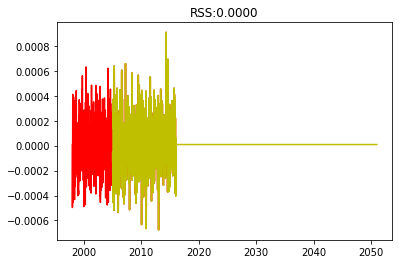

In [0]:
arima_plot(results_arima_value_trend,result_future_trend)

In [0]:
def arima_plot(data,results_arima_value):
    plt.plot(data,color='r')
    plt.plot(results_arima_value,color='y')
    plt.title('RSS:%.4f'%sum((results_arima_value-data)**2))

# Simple model

In [0]:
ssh=output['mean_ssh'].values

The shape of X is (6574, 4)
The shape of y is (6574,)
Model coefficients for [a1, a2, a3,a4]: [-6.59079186e-04  4.55743045e-10 -4.78319309e-03 -1.43346446e-03]
Model coefficient for b: 239.04375709425318


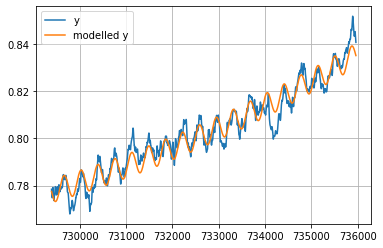

In [0]:
t=output['time'].values
w=1/365.25
x1 = t
x2 = t*t
x4 = np.sin(2*np.pi*w*t)
x5 = np.cos(2*np.pi*w*t)

X = np.vstack((x1,x2,x4,x5)).T
y= ssh
print('The shape of X is {}'.format(X.shape))
print('The shape of y is {}'.format(y.shape))

# 2: create the model, as before
model = LinearRegression(fit_intercept=True)

# 3: fit the model, as before
model.fit(X,y)

print('Model coefficients for [a1, a2, a3,a4]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

# 4: get predicted values for y, as before
y_hat = model.predict(X)

# 5: plot the real and modelled values
plt.figure()
plt.plot(t,y,label='y')
plt.plot(t,y_hat,label='modelled y')
plt.legend()
plt.grid()


The shape of X is (6574, 4)
The shape of y is (6574,)
Model coefficients for [a1, a2, a3,a4]: [-6.59079186e-04  4.55743045e-10 -4.78319309e-03 -1.43346446e-03]
Model coefficient for b: 239.04375709425318


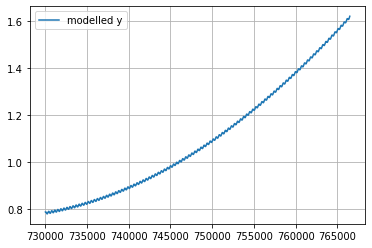

In [0]:
t=output['time'].values
w=1/365.25
x1 = t
x2 = t*t
x4 = np.sin(2*np.pi*w*t)
x5 = np.cos(2*np.pi*w*t)

X = np.vstack((x1,x2,x4,x5)).T
y= ssh
print('The shape of X is {}'.format(X.shape))
print('The shape of y is {}'.format(y.shape))

# 2: create the model, as before
model = LinearRegression(fit_intercept=True)

# 3: fit the model, as before
model.fit(X,y)

print('Model coefficients for [a1, a2, a3,a4]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))



end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1 = t_f
x2 = t_f*t_f
x4 = np.sin(2*np.pi*w*t_f)
x5 = np.cos(2*np.pi*w*t_f)

Xf = np.vstack((x1,x2,x4,x5)).T

# 4: get predicted values for y, as before
y_hat = model.predict(Xf)

# 5: plot the real and modelled values
plt.figure()
#plt.plot(t_f,y,label='y')
plt.plot(t_f,y_hat,label='modelled y')
plt.legend()
plt.grid()


In [0]:
t_2100=max(t+85*365)

In [0]:
#the prediction value of sea surface height (ssh) in 2100
y_model=(-6.59079186e-04)*t_2100+(4.55743045e-10)*t_2100*t_2100+(-4.78319309e-03)*np.sin(2*np.pi*w*t_2100)+(-1.43346446e-03)*np.cos(2*np.pi*w*t_2100)+( 239.04375709425318)
y_model

1.639851572360186

std is : 0.004079776675432786


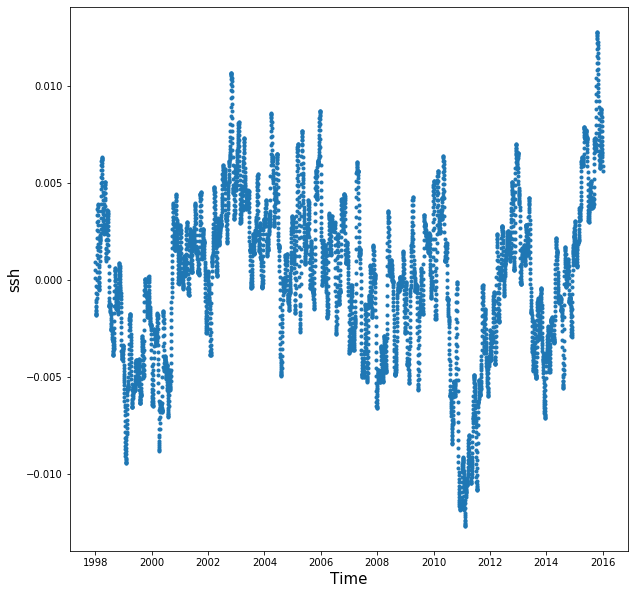

In [0]:
plt.figure(figsize=(10,10))
error=y-y_hat
plot_ts(t,error,'.','ssh')
print('std is :',std(error))

# Global map and local map

In [0]:
%%bigquery --project alert-ground-261008 output_global
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35
group by lon,lat
order by lon,lat

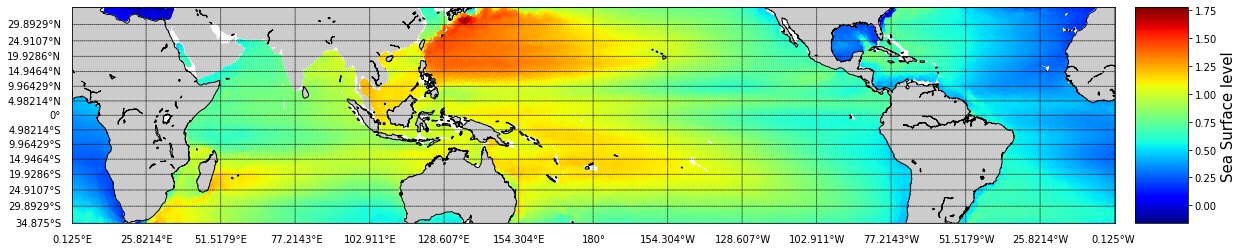

In [0]:
plt.figure(figsize=(20,40))
plot_im(output_global.lon,output_global.lat,output_global.mean_ssh,15,'Sea Surface level')

In [0]:
%%bigquery --project alert-ground-261008 output_1998
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35 AND time>=729390.0 AND time<=729755.0
group by lon,lat
order by lon,lat

In [0]:
output_1998

lon     lat  mean_ssh
0         0.125 -34.875  0.486679
1         0.125 -34.625  0.502424
2         0.125 -34.375  0.520139
3         0.125 -34.125  0.538591
4         0.125 -33.875  0.556819
...         ...     ...       ...
272498  359.875   3.875  0.389082
272499  359.875   4.125  0.383613
272500  359.875   4.375  0.376169
272501  359.875   4.625  0.369020
272502  359.875   4.875  0.364142

[272503 rows x 3 columns]

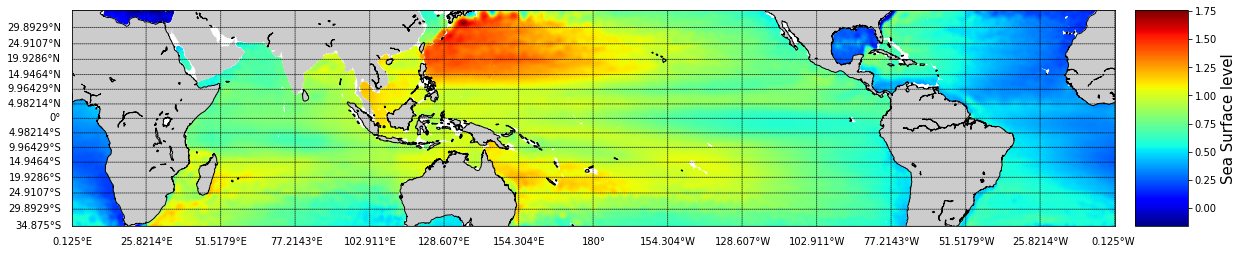

In [0]:
plt.figure(figsize=(20,40))
plot_im(output_1998.lon,output_1998.lat,output_1998.mean_ssh,15,'Sea Surface level')

In [0]:
%%bigquery --project alert-ground-261008 output_2015
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35 AND time>=735598.0 AND time<=735963.0
group by lon,lat
order by lon,lat

In [0]:
output_2015

lon     lat  mean_ssh
0         0.125 -34.875  0.620300
1         0.125 -34.625  0.626766
2         0.125 -34.375  0.620046
3         0.125 -34.125  0.607667
4         0.125 -33.875  0.600046
...         ...     ...       ...
272498  359.875   3.875  0.446321
272499  359.875   4.125  0.441486
272500  359.875   4.375  0.435059
272501  359.875   4.625  0.429825
272502  359.875   4.875  0.427596

[272503 rows x 3 columns]

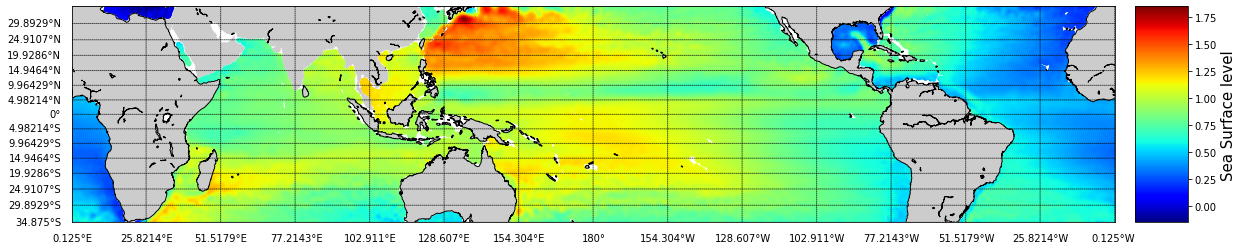

In [0]:
plt.figure(figsize=(20,40))
plot_im(output_2015.lon,output_2015.lat,output_2015.mean_ssh,15,'Sea Surface level')

In [0]:
df=pd.DataFrame(data=output_2015['lon'])

df['lat']= output_2015['lat']
df['difference']=output_2015['mean_ssh']-output_1998['mean_ssh']

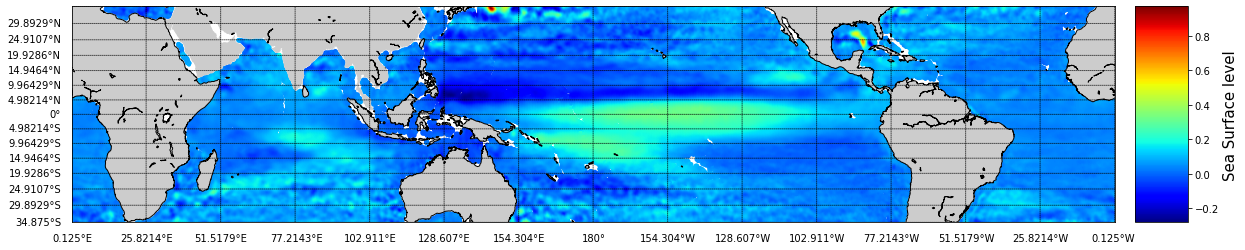

In [0]:
plt.figure(figsize=(20,40))
plot_im(df.lon,df.lat,df.difference,15,'Sea Surface level')

In [0]:
%%bigquery --project alert-ground-261008 output_2015_2
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-90 AND lat<=90 AND time>=735598.0 AND time<=735963.0
group by lon,lat
order by lon,lat

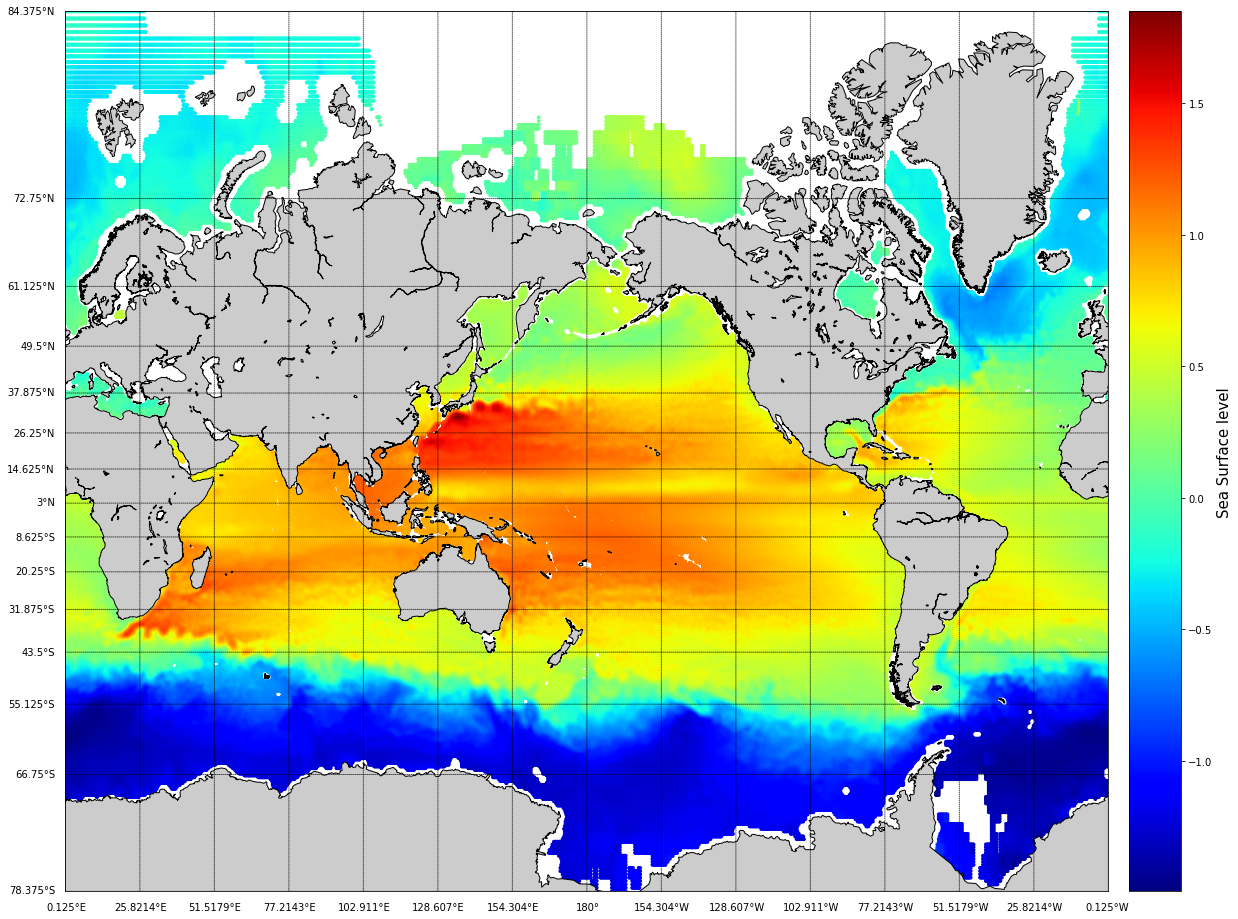

In [0]:
plt.figure(figsize=(20,30))
plot_im(output_2015_2.lon,output_2015_2.lat,output_2015_2.mean_ssh,15,'Sea Surface level')

In [0]:
output_2015_2

lon     lat  mean_ssh
0         0.125 -69.625 -1.374556
1         0.125 -69.375 -1.343030
2         0.125 -69.125 -1.333995
3         0.125 -68.875 -1.330216
4         0.125 -68.625 -1.328713
...         ...     ...       ...
560978  359.875  83.375 -0.217953
560979  359.875  83.625 -0.175044
560980  359.875  83.875 -0.168789
560981  359.875  84.125 -0.168567
560982  359.875  84.375 -0.174744

[560983 rows x 3 columns]

In [0]:
%%bigquery --project alert-ground-261008 output_2003_2
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-90 AND lat<=90 AND time>=731215 AND time<=731580
group by lon,lat
order by lon,lat

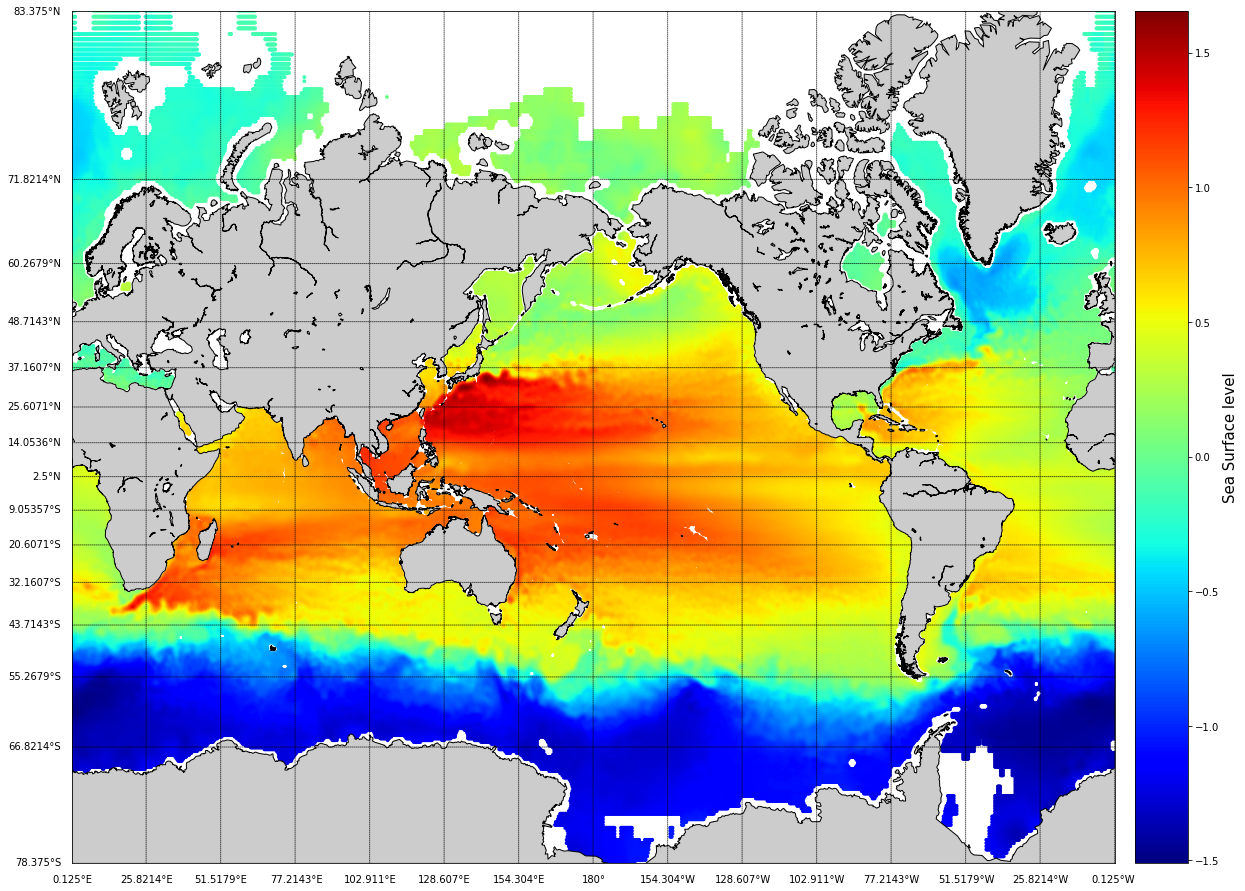

In [0]:
plt.figure(figsize=(20,40))
plot_im(output_2003_2.lon,output_2003_2.lat,output_2003_2.mean_ssh,15,'Sea Surface level')